In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import json
import itertools
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC']

data_dir = Path("../../../../Data/0archive/")

### Read data

In [11]:
def load_data(*path_globs):
    return pd.concat([
        pd.read_json(json_file, lines=True, encoding="utf-8")
        for json_file in itertools.chain(*[ json_dir.glob(path_glob) for path_glob in path_globs ])
    ], ignore_index=True, sort=False)

In [12]:
json_dir = data_dir / "中時電子報 (www.chinatimes.com) 5030a59d-81fe-11ea-8627-f23c92e71bad/2020-05-tokenized/"
df = load_data("2020-05-*.jsonl")

# take unique by publication_id and keep the biggest version
df = df.sort_values(["id", "version"], ascending=[1, 0])
df = df.drop_duplicates("id", keep="first")

print("The shape of the dataframe: ", df.shape)
df.head()

The shape of the dataframe:  (3073, 6)


,id,producer_id,version,title,text,comments
2230,000c0a09-ed2a-448e-bd72-592d54227023,5030a59d-81fe-11ea-8627-f23c92e71bad,1589036746,"[疫情, 重創, Uber, 大砍, 名, 員工, 財經, 中時, 電子報]","[受新, 冠, 肺炎, 疫情, 衝擊, 共享, 乘車, 服務公司, Uber, 周三, 日,...",[]
755,0029c3dd-82e8-414b-9d35-50dbe3fb5430,5030a59d-81fe-11ea-8627-f23c92e71bad,1588725189,"[杯, 咖啡, 害慘, 散戶, 驚爆, 陸企, ADR, 坑殺, 內幕, 財經, 中時, 電子報]","[清明節, 過後, 號稱, 星巴克, 咖啡, 在, 中國, 最強, 競爭對手, 的, 瑞幸,...",[]
169,002c56d6-e077-4c80-96b5-65cd161cc9a0,5030a59d-81fe-11ea-8627-f23c92e71bad,1588970566,"[億, 紓困, 過關, 廣發, 現金, 落空, 生活, 新聞, 中國時報]","[由, 行政院, 提出, 總金額, 達, 億, 的, 第二, 波, 防疫, 紓困, 預算, ...",[]
3030,0048b95d-dbc7-4680-8d89-c88b236b10cf,5030a59d-81fe-11ea-8627-f23c92e71bad,1588358297,"[確定, 脫, 北, 南韓, 議員, 爆, 金正恩, 上周, 已, 腦死, 國際, 中時, ...","[北韓, 最高, 領導人, 金正恩, 將近, 半月, 未, 出現, 在, 公開場合, 數個,...",[]
3059,008a2d6f-f324-40cb-8f9a-8fd0971dc044,5030a59d-81fe-11ea-8627-f23c92e71bad,1588438028,"[不是, 愷樂, 周揚青, 羅志祥, 被爆, 只, 對, 這, 女神, 認真, 娛樂, 中時...","[羅志祥, 小豬, 周揚, 青年, 情斷, 小豬, 旗下, 唯一, 女藝人, 愷, 樂, 蝴...",[]


### Prepare data

In [14]:
SVD_COMPONENTS = 300
N_CLUSTERS = 10

# 整理內文 for TfidfVectorizer 使用
document = []
for t in df["text"]:
    document.append(' '.join(t))
document = np.array(document)

print(document[0], '\n')

# Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2)
X = vectorizer.fit_transform(document)
print(f"Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}", '\n')

# use svd to reduce the number of features
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=SVD_COMPONENTS)
X = svd.fit_transform(X)
print(f"SVD Explained ratio: ", svd.explained_variance_ratio_.sum(), '\n')

# centering features
X = X-np.mean(X, axis=1).reshape(-1,1)

受新 冠 肺炎 疫情 衝擊 共享 乘車 服務公司 Uber 周三 日 向 美國 證監會 SEC 提出 文件 表示 將 裁員 名 人力 其 範圍 包括 招聘 部門 及 客戶服務 為 目前 總 員工 人數 預計 相關 遣散費 用 將 達 千萬美元 至於 裁員 方案 細節 則 將 在 兩周 內 公布 綜合 外電報導 疫情 影響 全球 經濟 造成 相關 運輸業 重創 導致 Uber 載客量 大幅 下降 逼不得已 Uber 選擇 裁減 人事 費用 支 出於 日 宣布 裁員 名 人力 此外 其 執行長 DaraKhosrowshahi 也 表示 將 會 放棄 今年 剩下 時間 的 基本 薪資 Uber 也 暗示 若 有 必要 將 會 採取 更多 措施 以 因應 市場 變化 Uber 預計 周四 公布 

Number of samples: 3073, Number of features: 17927 

SVD Explained ratio:  0.3273836189850547 



### Clustering

In [15]:
# KMeans clustering
from sklearn.cluster import KMeans
model = KMeans(n_clusters=N_CLUSTERS)
labels = model.fit_predict(X)

In [16]:
print("Number of articles in each group: ")
for l in np.unique(labels):
    print(f" {l}: ", len(np.where(labels==l)[0]))

Number of articles in each group: 
 0:  55
 1:  239
 2:  95
 3:  37
 4:  88
 5:  1547
 6:  288
 7:  159
 8:  21
 9:  544


### Examining results

In [24]:
# print out all articles that have the same labels
def print_all_articles_in_group(group_label):
    print(f"Articles of group {group_label}: \n")
    print(np.array(document)[np.where(labels==group_label)[0]])

# print articles that are closest to the cluster center (i.e. signature articles of a group)
def print_top_articles_in_group(group_label, top=5):
    X_dist = model.transform(X)
    group_article_ids = np.where(labels==group_label)[0]
    order = X_dist[:, group_label][group_article_ids].argsort()
    X_dist[:, group_label][group_article_ids][order]

    top_article_ids = group_article_ids[order][:top]

    print(f"Top {top} articles of group {LABEL}: \n")
    print(np.array(document)[top_article_ids])

In [19]:
print_articles_in_group(0)

Articles of group 0: 

['羅志祥 小豬 周揚 青年 情斷 小豬 旗下 唯一 女藝人 愷 樂 蝴蝶 姐姐 是否 會 被 扶正 也 成為 外界 關注 焦點 不過 資深 媒體 人 許聖梅 日前 更 在 節目 中 驚爆 在 羅志祥 落落長 的 緋聞 名單 中 唯獨 對 一位 女神 認真 那 就是 Selina 任家萱 羅志祥 過去 受訪 時 曾 透露 媽媽 喜歡 的 媳婦 條件 包括 有點 肉肉 的 喜歡 小 動物 還有 個性 大剌剌 許聖梅 直言 羅 媽媽 講 的 就是 Selina 而 Selina 更是 改變 了 羅志祥 人生 Selina 年 被 拍到 與 羅志祥 打網球 交往 傳聞 不脛而走 雖然 兩 人 都 矢口否認 戀情 但 Selina 卻 經常 陪著 羅 媽媽 打麻將 連羅 媽媽 都 覺得 這個 女生 真不錯 許聖梅'
 '大陸 網紅 周揚青 與 羅志祥 小豬 年 情斷 她 一封 分手 信 指控 羅志祥 約妹 私生活 亂 等 罪狀 其中 周揚青 指控 小豬 與 旗下 女藝人 有 不 正常 關係 還 讓 愷 樂 捲入 風波 豬 揚 情變 風波 延燒 至今 原 在 IG 噤聲 的 周揚青 昨日 晚 終於 在 IG 發文 吐 近況 周揚青 昨晚 陸續 在 IG 限時 動態 曝光 自己 染 了 一頭 金髮 並 發文 曬 穿 搭照 只見 周揚青 身穿 黑底 白點 深 V 小 洋裝 讓 她 一雙 美腿 和 前 凸 後 翹 身材 全都 露 就 有 網友 問 最近 過 得 好 嗎 周揚青 也 親民 回 不錯 不過 她 的 符號 也 引發 網 留言 波浪 符號 喔 你 的 波浪 號 其實 網友會 討論 符號 全 因為 愷 樂 日前 發文 向 周揚青 道歉 時 PO 文中 出'
 '周揚青 結束 和 羅志祥 年 戀情 後 一舉一動 仍 受到 大眾 關注 外界 普遍 認為 周揚青 身家 背景 不 一般 更是 被 家人 富養 寵大 今日 傍晚 她 在 微博 透露 和 家人 相處 發生 的 糗事 讓 她 看清楚 自己 在家 裡 的 地位 居然 不如 一條 貓 今日 傍晚 點半 左右 周揚青 在 她 的 微博 小號 更新 近況 說 北京 氣溫 高達 度 她 在家 裡 熱 到 快 昏過去 想 開啟 家裡 的 中央空調 但 她 的 媽媽 卻 甩 狠話 昨天 才給你

In [21]:
print_articles_in_group(2)

Articles of group 2: 

['北韓 最高 領導人 金正恩 將近 半月 未 出現 在 公開場合 數個 重要 節日 亦 未 現身 加上 外媒 傳出 他 一度 陷入 病危 雖然 南韓 官方 否認 此 一 傳聞 但 至今 仍 眾說紛紜 而 從 北韓 逃脫 的 南韓 未來 韓國 黨 議員 池成浩 透露 金正恩 確定 已經 死亡 韓 媒 ChosunBiz 報導 池成浩 於 月 日 通過 電話 受訪 表示 金正恩 在 上周末 已經 因為 手術 後遺症 死亡 根據 美國有線電視新聞網 先前 報導 金正恩 曾 接受 心血管 手術 後 陷入 病危 池成浩 表示 金正恩 是 在 接受 心血管 手術 後 因 手術 休克 而 死亡 且 目前 北韓 內部 局勢 已 出現 混亂 至於 北韓 為何 仍 未有 正式 聲明 正如 當年 他 的 父親 金正日 過世 後 一周 才 發'
 '隨著 北韓 最高 領導人 金正恩 出席 順天 磷肥廠 竣工 儀式 相關 關於 他 已 陷入 病危 植物人 甚至 已 腦死 等 傳聞 也 一掃而空 繼續 主掌 北韓 軍政 大權 不過 在 先前 謠言 滿天飛 前 金正恩 的 妹妹 金與正 一度 被 外 傳為 最 可能 的 接班人 而 有 專家 注意到 就 在 金正恩 出席 剪綵 儀式 時金 與 正 破例 與 他 一同 坐在 主席台 排 第位 確定 她 是 金正恩 政權 實際上 的 二把手 據 韓 媒 朝鮮 日報 報導 由於 先前 曾多次 替 哥哥 擬定 對外 發言 讓 在 金正恩 神隱 的 多日 以來 現任 朝鮮勞動黨中央 委員 第一副 部長 的 金 與 正 一直 備受矚目 一旦 金正恩 不能 視事 她 是否 可能 成為 金氏 政權 接班人 雖然 金正恩 已於 日 公開 亮相 但 同場 出席 的'
 '北韓 領導人 金正恩 神隱 天 後 北韓 官媒 今 發布 昨 金正恩 出席 五一勞動節 活動 的 照片 一舉 粉碎 外界 謠傳 他 已 死 的 傳言 對此 韓 媒 解析 金正恩 為何 會 現身 的 關鍵 原因 據 北韓 官媒 朝中社 日 報導 順天 磷肥廠 竣工 儀式 於 月 日 勞動節 隆重舉行 金正恩 當天 有 出席 竣工 儀式 顯示 金正恩 仍 健在 韓聯社 對此 分為 兩 方面 來 探討 首先 金正恩 為何 現身 在 順天 磷肥廠 因為 北韓 

In [25]:
print_top_articles_in_group(8)

Top 5 articles of group 0: 

['中時 電子報 對 留言 系統 使用者 發布 的 文字 圖片 或 檔案 保有 片面 修改 或 移除 的 權利 當 使用者 使用 本 網站 留言 服務 時 表示 已 詳細 閱讀 並 完全 了解 且 同意 配合 下述 規定 違反 上述 規定 者 中時 電子報 有權 刪除 留言 或者 直接 封鎖 帳號 請 使用者 在 發言 前 務必 先 閱讀 留言板 規則 謝謝 配合'
 '中時 電子報 對 留言 系統 使用者 發布 的 文字 圖片 或 檔案 保有 片面 修改 或 移除 的 權利 當 使用者 使用 本 網站 留言 服務 時 表示 已 詳細 閱讀 並 完全 了解 且 同意 配合 下述 規定 違反 上述 規定 者 中時 電子報 有權 刪除 留言 或者 直接 封鎖 帳號 請 使用者 在 發言 前 務必 先 閱讀 留言板 規則 謝謝 配合'
 '中時 電子報 對 留言 系統 使用者 發布 的 文字 圖片 或 檔案 保有 片面 修改 或 移除 的 權利 當 使用者 使用 本 網站 留言 服務 時 表示 已 詳細 閱讀 並 完全 了解 且 同意 配合 下述 規定 違反 上述 規定 者 中時 電子報 有權 刪除 留言 或者 直接 封鎖 帳號 請 使用者 在 發言 前 務必 先 閱讀 留言板 規則 謝謝 配合'
 '中時 電子報 對 留言 系統 使用者 發布 的 文字 圖片 或 檔案 保有 片面 修改 或 移除 的 權利 當 使用者 使用 本 網站 留言 服務 時 表示 已 詳細 閱讀 並 完全 了解 且 同意 配合 下述 規定 違反 上述 規定 者 中時 電子報 有權 刪除 留言 或者 直接 封鎖 帳號 請 使用者 在 發言 前 務必 先 閱讀 留言板 規則 謝謝 配合'
 '中時 電子報 對 留言 系統 使用者 發布 的 文字 圖片 或 檔案 保有 片面 修改 或 移除 的 權利 當 使用者 使用 本 網站 留言 服務 時 表示 已 詳細 閱讀 並 完全 了解 且 同意 配合 下述 規定 違反 上述 規定 者 中時 電子報 有權 刪除 留言 或者 直接 封鎖 帳號 請 使用者 在 發言 前 務必 先 閱讀 留言板 規則 謝謝 配合']


In [26]:
print_top_articles_in_group(4)

Top 5 articles of group 0: 

['國內 新冠 肺炎 在 連續 天無 新增 個案 後 破功 一次 增加 名 境外 移入 確診 其中 案 是 一對 夫婦 從 西非 到 法國 轉機 返台 機上 空服員 爆料 兩 人 早在 上機 前 就 告知 喉嚨痛 機上 更是 狂 吃 喉糖 試圖 止咳 減緩 喉嚨 不適 案 與 為 一對 夫婦 月 日 至 塞內加爾 工作 陸續 於 月 日日 出現 全身 倦怠 及 咳嗽 等 症狀 兩 人 月 日 返國 入境 時因 仍 有 咳嗽 症狀 由 機場 檢疫 人員 採檢 通報 確診 TVBS 報導 這 對 夫妻 其實 還 帶著 個 小孩 回台 在 上機 前 就 先 說 有 喉嚨痛 在 從 巴黎 返台 的 班機 上 更是 一直 吃 喉糖 想 止咳 舒緩 喉嚨痛 一旁 的 商務艙 乘客 嚇 得 只能 把 自己 包 緊緊 之'
 '新冠 病毒 全球 肆虐 又 一 大國 落難 俄羅斯 日 驚傳 暴增 名 確診 累計 案例 衝高 到 近 萬千 人居 全球 第 儘管 官方 和 專家 把 確診 狂飆 定調為 篩檢 能量 大增 導致 但 位居 疫情 震央 的 首都 莫斯科 市長 甚至 語出驚人 稱 全市 居民 已 遭 感染 莫斯科 市長 籲 落實 隔離 這 是 俄國 首度 單日 確診 突破 位數 其中 逾 半 來自 莫斯科 全國 確診 第一 同樣 是 莫斯科 約 萬千 人 超過 半數 公衛 體系 憂心 莫斯科 的 醫療機構 恐怕 難以 負荷 目前 當地 已 設立 多處 臨時 醫院 市長 蘇比雅寧 表示 根據 研究 莫斯科 萬 民眾 中 恐怕 已有 被 感染 換算 約 萬 人 遠高於 官方 數據 他 警告 顯然 威'
 '據 韓 媒 報導 南韓 在 連續 天無 新增 本土 新冠 確診 病例 後 一名 居住 在 京畿道 龍仁市 的 歲 男性 A 某日 被 確診 據悉 A 某 曾 在 一 晚上 光顧 梨泰 院家 夜 店家 夜店 當天 共 接待 了 千多名 客人 引發 附近 民眾 對 第二輪 社區 感染 的 擔憂 中新網 日 引據 韓 媒 報導 A 某 在 黃金 休假 期間 曾 在 一 晚上 小時 內 輾轉 首爾 梨泰 院家 夜店 當局 擔心 發生 集體 感染 的 可能性 較大 據 推測 家 夜店 加起來 大約 有人 因此 首爾市 和 疾病 管理

### Visualization

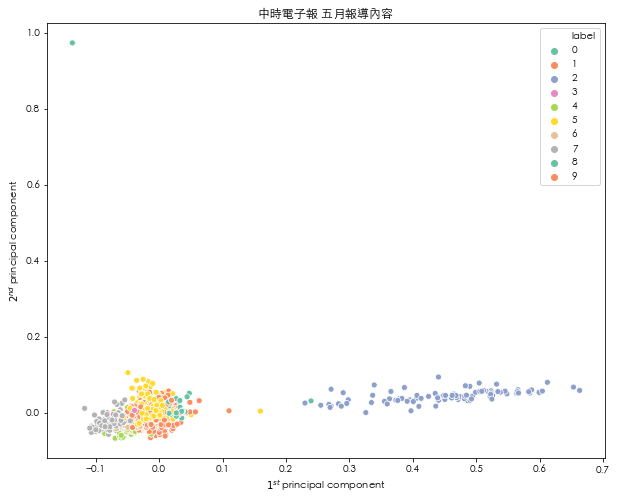

In [27]:
# project to 2d for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_comps = pca.fit_transform(X)

# create a dataframe for plotting
cluster_df = pd.DataFrame({"x": X_comps[:, 0], "y": X_comps[:, 1], "label": labels})

# plot
plt.figure(figsize=(10, 8))
import seaborn as sns
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x="x", y="y", hue="label", data=cluster_df, legend="full", palette="Set2")
plt.title("中時電子報 五月報導內容")
plt.xlabel(r"$1^{st}$ principal component")
plt.ylabel(r"$2^{nd}$ principal component")
plt.savefig("chinatimes-may-topic.png")